## Website Traffic Time Series
Author: Aditya Srivastava <br>
Date: Jan 18th 2022

### Introduction

Often companies want to analyze the brand value they possess in the digital space or qunatify their online user engagement. One of the ways is by monitoring the traffic that their website produces, tracking growth based on new users, analyzing trend of existing users for retention and churn rate, uncovering certain trend patterns and forecasting the traffic that is supposed to follow to be better equiped for the future and take business along with computational decisions accordingly.<br>
This project is based on analyzing the current trend and seasonalitites as well as predict the future traffic landings on a website from new users to quantify growth using machine learning time series model.

### Data Source

The pageviews data is that of the website http://statforecasting.com/ of almost 6 years of data from 2014 to 2020. The data is publicly available and can be downloaded from [Kaggle](https://www.kaggle.com/bobnau/daily-website-visitors).

### Data Dictionary

| Column            | Description                | Data Type |
|:---               |:---                        |:----------|
| Row               | Row number                 | Integer   |
| Day               | Day of the week in text    | String    |
| Day.Of.Week       | Day of the week in numeric | Integer   | 
| Date              | Date in mm/dd/yyyy format  | String    | 
| Page.Loads        | Daily number of pages loaded  | String    | 
| Unique.Visits     | Daily number of visitors from whose IP addresses there haven't been hits on any page in over 6 hours  | String    | 
| First.Time.Visits | Number of unique visitors who do not have a cookie identifying them as a previous customer  | String    | 
| Returning.Visits  | Number of unique visitors minus first time visitors  | String    | 

### Exploratory Data Analysis

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.formula.api import ols
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# reading data

df = pd.read_csv('daily-website-visitors.csv')
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [3]:
# structure of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB


There are 2167 rows and 8 columns where each row represents the number of pageviews and visitors on a daily basis.

<br>
Based on the structure of the dataframe, the following code removes redundant and no-value columns, changes data types of page metrics to integers and standardizes the column names.

In [4]:
# making structural changes for standardization 

df.drop(['Row', 'Day.Of.Week'], axis = 1, inplace = True)
df = df.replace(',', '', regex = True)
columns = df.columns
metric_columns = columns[2:]
for column in metric_columns:
    df[column] = df[column].astype('int64')
df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')
df.rename(columns = {
    'Day': 'day',
    'Date': 'date',
    'Page.Loads': 'page_loads',
    'Unique.Visits': 'unique_visits',
    'First.Time.Visits': 'first_visits',
    'Returning.Visits': 'return_visits'
}, inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   day            2167 non-null   object        
 1   date           2167 non-null   datetime64[ns]
 2   page_loads     2167 non-null   int64         
 3   unique_visits  2167 non-null   int64         
 4   first_visits   2167 non-null   int64         
 5   return_visits  2167 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 101.7+ KB


In [6]:
df.head()

,day,date,page_loads,unique_visits,first_visits,return_visits
0,Sunday,2014-09-14,2146,1582,1430,152
1,Monday,2014-09-15,3621,2528,2297,231
2,Tuesday,2014-09-16,3698,2630,2352,278
3,Wednesday,2014-09-17,3667,2614,2327,287
4,Thursday,2014-09-18,3316,2366,2130,236


In [7]:
# checking for missing values
df.isna().sum()

day              0
date             0
page_loads       0
unique_visits    0
first_visits     0
return_visits    0
dtype: int64

No missing values were found.

In [8]:
# getting date range
print(f"The data ranges from {df['date'].min().date()} to {df['date'].max().date()}")

The data ranges from 2014-09-14 to 2020-08-19


<br>
Following is the summary statistics of the dataframe.

In [9]:
# summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
page_loads,2167.0,4116.989386,1350.977843,1002.0,3114.5,4106.0,5020.5,7984.0
unique_visits,2167.0,2943.646516,977.886472,667.0,2226.0,2914.0,3667.5,5541.0
first_visits,2167.0,2431.824181,828.704688,522.0,1830.0,2400.0,3038.0,4616.0
return_visits,2167.0,511.822335,168.736370,133.0,388.5,509.0,626.5,1036.0


* The website mostly garners traffic from new users
* All of the metrics seem to be normally distributed as mean and median are very close

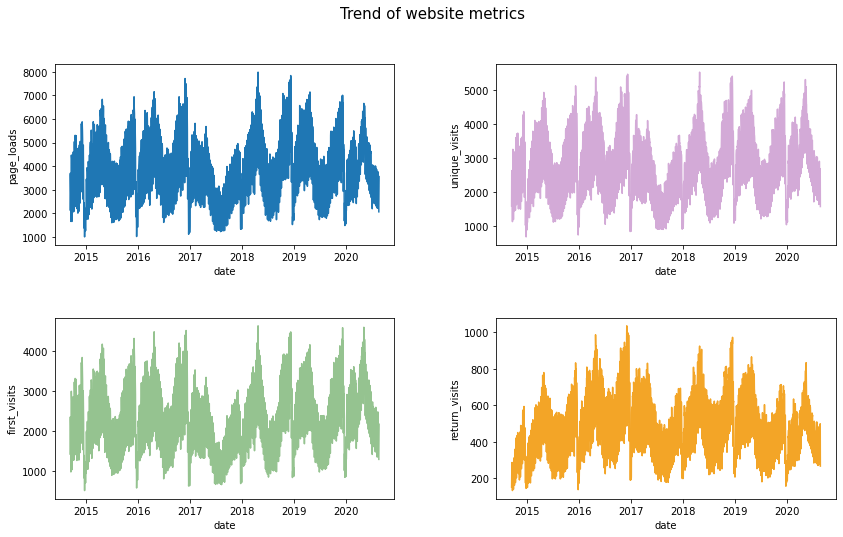

In [10]:
# plotting trend graph for all page metrics

figure, axes = plt.subplots(2, 2, 
                            figsize = (14, 8), 
                            gridspec_kw = {
                                'hspace': 0.4,
                                'wspace': 0.3
                            })
sns.lineplot(x='date', y='page_loads', data=df, ax = axes[0, 0])
sns.lineplot(x='date', y='unique_visits', color='#D3AAD7', data=df, ax = axes[0, 1])
sns.lineplot(x='date', y='first_visits', color='#95C390', data=df, ax = axes[1, 0])
sns.lineplot(x='date', y='return_visits', color='#F3A527', data=df, ax = axes[1, 1])
_ = figure.suptitle('Trend of website metrics', fontsize=15)

* All the metrics exhibit similar behaviour and are highly correlated
* There is seasonality and cyclicity in all the metrics

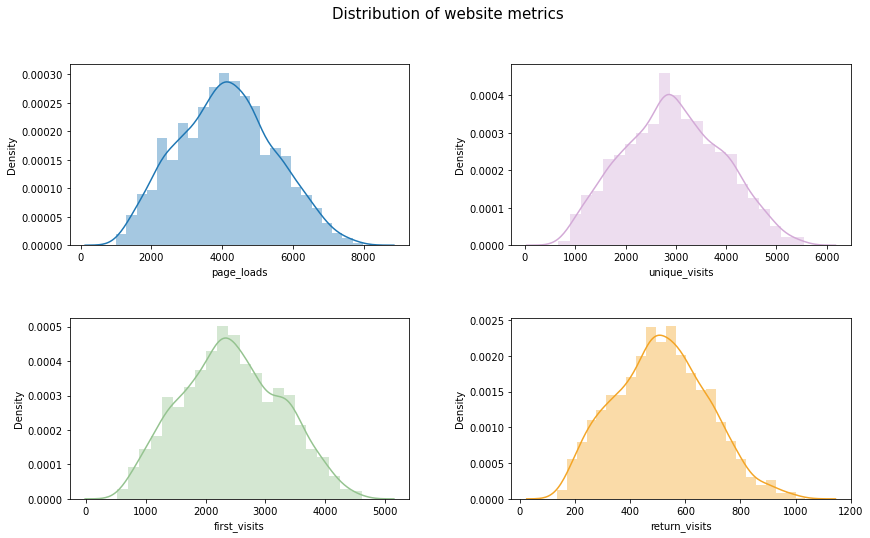

In [11]:
# getting distribution of page metrics

figure, axes = plt.subplots(2, 2, 
                            figsize = (14, 8), 
                            gridspec_kw = {
                                'hspace': 0.4,
                                'wspace': 0.3
                            })
sns.distplot(df['page_loads'], ax = axes[0, 0])
sns.distplot(df['unique_visits'], color='#D3AAD7', ax = axes[0, 1])
sns.distplot(df['first_visits'], color='#95C390', ax = axes[1, 0])
sns.distplot(df['return_visits'], color='#F3A527', ax = axes[1, 1])
_ = figure.suptitle('Distribution of website metrics', fontsize=15)

As found from the summary statistics, the metrics are normally distributed with decent spread.

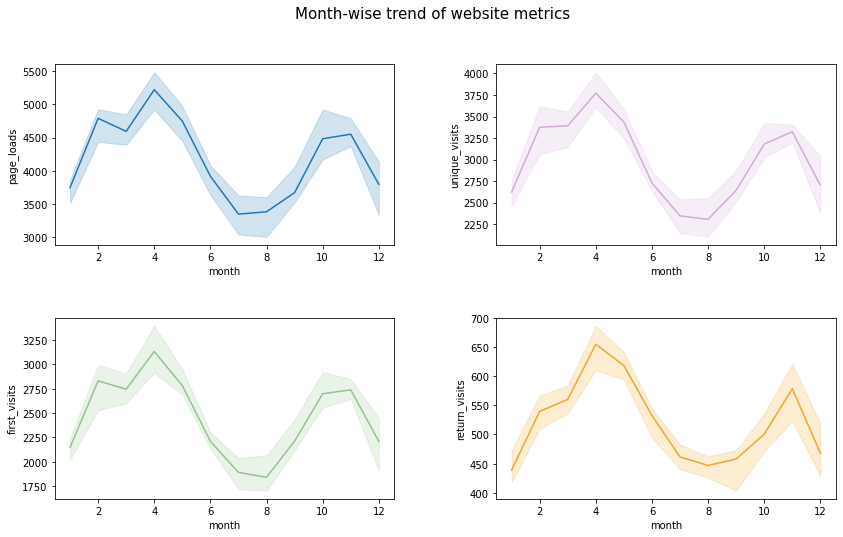

In [12]:
# getting month-wise trend of page metrics for seasonality

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

figure, axes = plt.subplots(2, 2, 
                            figsize = (14, 8), 
                            gridspec_kw = {
                                'hspace': 0.4,
                                'wspace': 0.3
                            })
sns.lineplot(x='month', y='page_loads', data=df, estimator = np.median, ax = axes[0, 0])
sns.lineplot(x='month', y='unique_visits', color='#D3AAD7', data=df, estimator = np.median, ax = axes[0, 1])
sns.lineplot(x='month', y='first_visits', color='#95C390', data=df, estimator = np.median, ax = axes[1, 0])
sns.lineplot(x='month', y='return_visits', color='#F3A527', data=df, estimator = np.median, ax = axes[1, 1])
_ = figure.suptitle('Month-wise trend of website metrics', fontsize=15)

The spring season has most page loads and visits as compared to summer and fall. Since this being an academic website, the reason might be that the course is taught in spring.

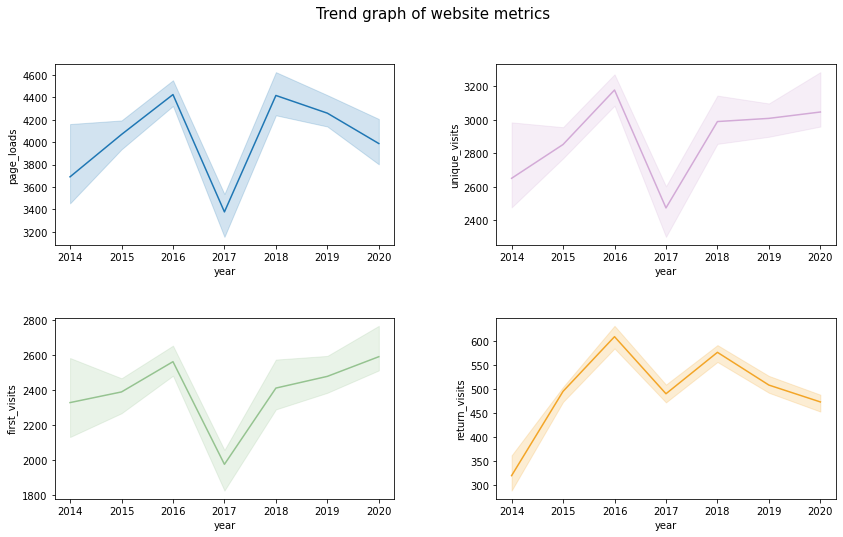

In [13]:
# getting year-wise trend of page metrics

figure, axes = plt.subplots(2, 2, 
                            figsize = (14, 8), 
                            gridspec_kw = {
                                'hspace': 0.4,
                                'wspace': 0.3
                            })
sns.lineplot(x='year', y='page_loads', data=df, estimator = np.median, ax = axes[0, 0])
sns.lineplot(x='year', y='unique_visits', color='#D3AAD7', data=df, estimator = np.median, ax = axes[0, 1])
sns.lineplot(x='year', y='first_visits', color='#95C390', data=df, estimator = np.median, ax = axes[1, 0])
sns.lineplot(x='year', y='return_visits', color='#F3A527', data=df, estimator = np.median, ax = axes[1, 1])
_ = figure.suptitle('Trend graph of website metrics', fontsize=15)

2017 was an unusual year which will require inside knowledge to know the reason. It would be interesting to see if 2017 data should be utilized while modelling. In the later years, while the page loads and return visits are on decline, the number of new users coming onto the website shows an upward trend. This could mean overall the website is showcasing decline, but there are some relevant pages content-wise and quality-wise which is attracting new users to come onto those pages.

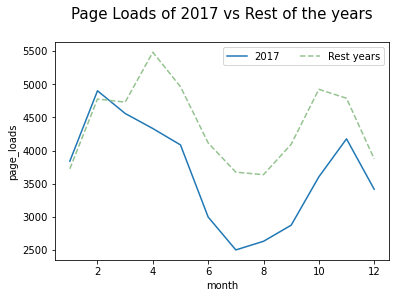

In [14]:
# investigating 2017 if the metrics drop was consistent across months

year_2017 = df[df['year'] == 2017]
rest_year = df[df['year'] != 2017]
l1 = sns.lineplot(x='month', y='page_loads', data=year_2017, estimator = np.median, ci=None)
l2 = sns.lineplot(x='month', y='page_loads', data=rest_year, estimator = np.median, ci=None, color='#95C390', linestyle='--')
labels = ['2017', 'Rest years']
plt.legend([l1, l2], labels=labels, ncol=2)
_ = plt.title('Page Loads of 2017 vs Rest of the years\n', fontsize=15)

The page loads(and correspondingly other metrics) in 2017 saw a decline which was consistent from March-December as compared to rest of the years. Rather than certain months acting as anomaly, the issue seems to be something else.

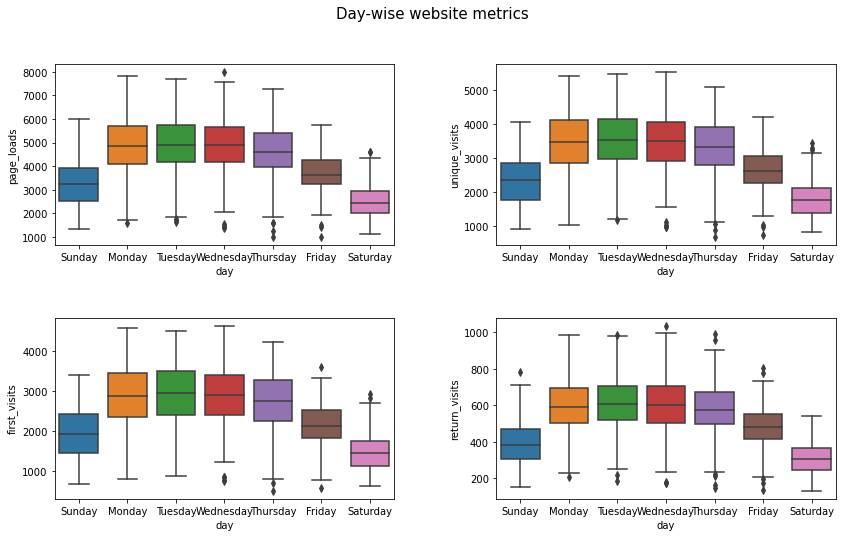

In [15]:
# day-wise page metrics

figure, axes = plt.subplots(2, 2, 
                            figsize = (14, 8), 
                            gridspec_kw = {
                                'hspace': 0.4,
                                'wspace': 0.3
                            })
sns.boxplot(x='day', y='page_loads', data=df, ax = axes[0, 0])
sns.boxplot(x='day', y='unique_visits', data=df, ax = axes[0, 1])
sns.boxplot(x='day', y='first_visits', data=df, ax = axes[1, 0])
sns.boxplot(x='day', y='return_visits', data=df, ax = axes[1, 1])
_ = figure.suptitle('Day-wise website metrics', fontsize=15)

Weekdays see major traffic as compared to weekends with few outliers.

### Linear Regression

In [16]:
# Regressing first visits on date

model_df = df.copy()
model_df['date'] = model_df['date'].map(datetime.toordinal)
model = ols('first_visits ~ date', data=model_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           first_visits   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     14.77
Date:                Mon, 07 Feb 2022   Prob (F-statistic):           0.000125
Time:                        23:24:18   Log-Likelihood:                -17629.
No. Observations:                2167   AIC:                         3.526e+04
Df Residuals:                    2165   BIC:                         3.527e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.787e+04   2.09e+04     -3.727      0.0

* There is a statistical significance with respect to time as seen from p-value which concludes that the observations are time-dependent.
* R-squared is 0.7% which is insignificant. The variance that is shown in new users visits cannot be explained via linear regression.

In [17]:
# reading data

df = pd.read_csv('daily-website-visitors.csv')
df.drop(['Row', 'Day.Of.Week'], axis = 1, inplace = True)
df = df.replace(',', '', regex = True)
columns = df.columns
metric_columns = columns[2:]
for column in metric_columns:
    df[column] = df[column].astype('int64')
df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')
df.rename(columns = {
    'Day': 'day',
    'Date': 'date',
    'First.Time.Visits': 'n_first_visits',
}, inplace = True)
df.drop(['Page.Loads', 'Unique.Visits', 'Returning.Visits'], axis=1, inplace=True)
df.head()

,day,date,n_first_visits
0,Sunday,2014-09-14,1430
1,Monday,2014-09-15,2297
2,Tuesday,2014-09-16,2352
3,Wednesday,2014-09-17,2327
4,Thursday,2014-09-18,2130


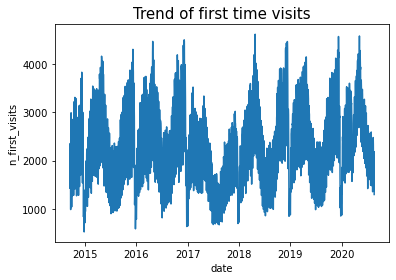

In [18]:
# ploting first time visits
sns.lineplot(x='date', y='n_first_visits', data=df)
_ = plt.title('Trend of first time visits', fontsize=15)

* Visually, it looks like a stationary time-series which is mean reverting at around 2200 first time visits and has constant variance ranging from 800-4200
* There seems to be a seasonality of a year. Since this being a record of academic webiste, the seasonality in all likelihood depends upon in which semester the courses are taught.

In [19]:
# ADF and KPSS test for checking if time series is stationary
adf_result = adfuller(df['n_first_visits'])
print(f"ADF: {adf_result[1]:.4f}, which states that our hypothesis of being a stationary time series is {True if adf_result[1] < 0.05 else False}")
statistic, p_value, n_lags, critical_values = kpss(df['n_first_visits'])
print(f'KPSS Test: The series is {"not " if p_value < 0.05 else ""}stationary')

ADF: 0.0002, which states that our hypothesis of being a stationary time series is True
KPSS Test: The series is stationary


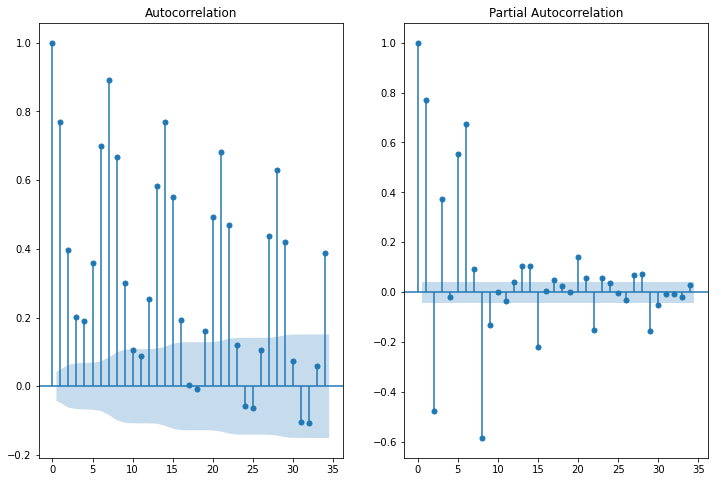

In [20]:
# plotting ACF and PACF plots
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_acf(df['n_first_visits'], ax=ax1)
fig = sm.graphics.tsa.plot_pacf(df['n_first_visits'], ax=ax2)

* ACF shows dampening effect as well as seasonality effect
* PACF is oscillating around 0 as positive and negative
* The above two points could mean the series is auto-regressive
* The confidence interval continues to cut PACF till the 3rd lag
* The model could be ARIMA(3, 0, 0)
* The next cut-off value seems to be at 9 which will also be tested

In [21]:
# testing ARIMA models on original data
AIC, BIC = [], []
ar, ma = [3, 3, 9, 9], [0, 9, 0, 9]
for p, q in zip(ar, ma):
    model = ARIMA(df['n_first_visits'], order=(p, 0, q)).fit()
    AIC.append(int(model.aic))
    BIC.append(int(model.bic))
print("AIC's:", AIC)
print("BIC's", BIC)
print(f"The ARIMA model according to AIC is ARIMA({ar[AIC.index(min(AIC))]}, 0, {ma[AIC.index(min(AIC))]})")
print(f"The ARIMA model according to BIC is ARIMA({ar[BIC.index(min(BIC))]}, 0, {ma[BIC.index(min(BIC))]})")

AIC's: [32442, 30023, 29370, 29005]
BIC's [32471, 30103, 29433, 29119]
The ARIMA model according to AIC is ARIMA(9, 0, 9)
The ARIMA model according to BIC is ARIMA(9, 0, 9)


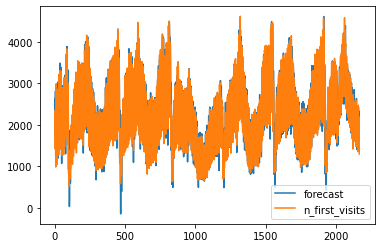

In [22]:
# plotting against in-sample data
model = ARIMA(df['n_first_visits'], order=(9, 0, 9))
model_fit = model.fit(disp=0)
_ = model_fit.plot_predict(dynamic=False)

RMSE on trained period is: 194.84


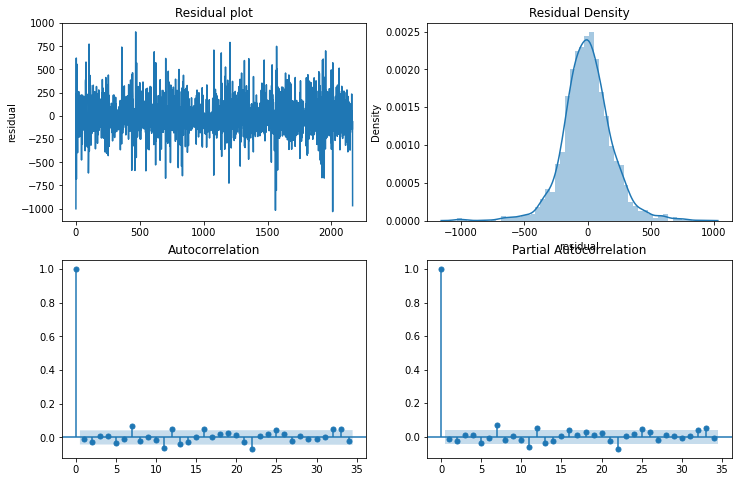

In [23]:
# Residual diagnostics
print(f'RMSE on trained period is: {np.sqrt(np.mean(model_fit.resid ** 2)):.2f}')
residuals = pd.DataFrame(model_fit.resid, columns=['residual'])
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.lineplot(x=residuals.index, y="residual", data=residuals, ax=ax[0, 0])
ax[0, 0].set_title("Residual plot")
sns.distplot(residuals["residual"], ax=ax[0, 1])
ax[0, 1].set_title("Residual Density")
sm.graphics.tsa.plot_acf(residuals['residual'], ax=ax[1, 0])
_ = sm.graphics.tsa.plot_pacf(residuals['residual'], ax=ax[1, 1])

* RMSE looks good in comparison to the actual visits we get
* Residuals are mean reverting and follow a normal distribution around 0 and decent kurtosis
* There doesn't seem to be any auto-correlation between residuals as we don't see any dampening effect in ACF

In [24]:
# Box-Ljung test for residual autocorrelation
blt = sm.stats.acorr_ljungbox(model_fit.resid, lags=9, return_df=True)
print(f"Minimum p-value: {blt['lb_pvalue'].min()}")
print(f"Median p-value: {blt['lb_pvalue'].mean()}")
print(f"Mean p-value: {np.median(blt['lb_pvalue'])}")

Minimum p-value: 0.03183363133158986
Median p-value: 0.3728174381589185
Mean p-value: 0.4203064609877588


The first 9 lags show a median p-value of 0.37, which is greater than 0.05. Hence we reject the null hypothesis that states the residuals being auto-correlated

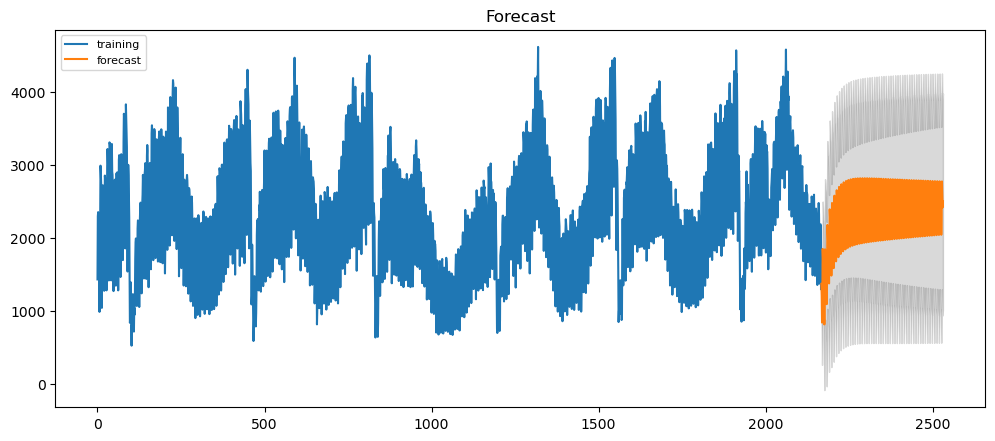

In [25]:
# calculating forecast for next 1 year
n_periods = 365
fc, se, conf = model_fit.forecast(n_periods, alpha=0.05)
fc_index = np.arange(len(df['n_first_visits']), len(df['n_first_visits']) + n_periods)
fc_series = pd.Series(fc, index=fc_index)
lower_series = pd.Series(conf[:, 0], index=fc_index)
upper_series = pd.Series(conf[:, 1], index=fc_index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['n_first_visits'], label='training')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                  color='k', alpha=.15)
plt.title('Forecast')
_ = plt.legend(loc='upper left', fontsize=8)

* Something is off. Somehow the forecast did not capture the variability that was expected of the model.
* Two reasons that I could think of are overfitting and not capturing seasonlity

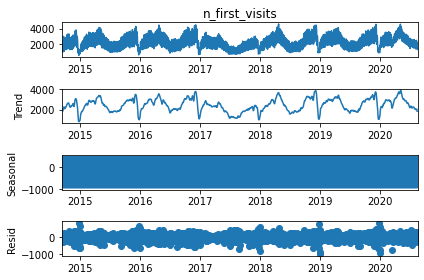

In [26]:
# decomposing time-series into trend and seasonality
df_copy = df.copy()
df_copy.index = df['date']
result = seasonal_decompose(df_copy['n_first_visits'], model='additive')
_ = result.plot()

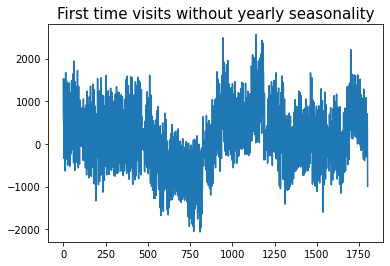

In [27]:
# getting differenced data with seasonality of a year
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
differenced = difference(df['n_first_visits'], 365)
plt.plot(differenced)
_ = plt.title('First time visits without yearly seasonality', fontsize=15)

In [28]:
# checking if the seasonality-differenced data is stationary
adf_result = adfuller(differenced)
print(f"ADF: {adf_result[1]:.4f}, which states that our hypothesis of being a stationary time series is {True if adf_result[1] < 0.05 else False}")
statistic, p_value, n_lags, critical_values = kpss(differenced)
print(f'KPSS Test: The series is {"not " if p_value < 0.05 else ""}stationary')

ADF: 0.0485, which states that our hypothesis of being a stationary time series is True
KPSS Test: The series is not stationary


In [29]:
# differencing the data by 1 to make it stationary. No need of variance stationary required it seems.
differenced_copy = np.copy(differenced)
for i in range(len(differenced_copy) - 1, 0, -1):
    differenced_copy[i] = differenced_copy[i] - differenced_copy[i - 1]
differenced_copy = np.delete(differenced_copy, 0)

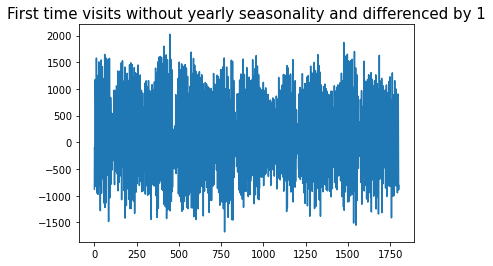

In [30]:
plt.plot(differenced_copy)
_ = plt.title('First time visits without yearly seasonality and differenced by 1', fontsize=15)

The data looks mean and variance stationary

In [31]:
# checking if the differenced data is stationary
adf_result = adfuller(differenced_copy)
print(f"ADF: {adf_result[1]:.4f}, which states that our hypothesis of being a stationary time series is {True if adf_result[1] < 0.05 else False}")
statistic, p_value, n_lags, critical_values = kpss(differenced_copy)
print(f'KPSS Test: The series is {"not " if p_value < 0.05 else ""}stationary')

ADF: 0.0000, which states that our hypothesis of being a stationary time series is True
KPSS Test: The series is stationary


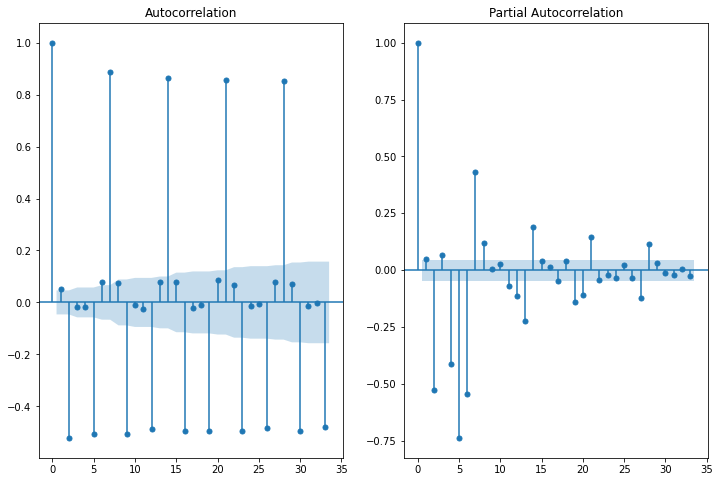

In [32]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_acf(differenced_copy, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(differenced_copy, ax=ax2)

Do the recurring peaks still say there is seasonality?
* Looks like a MA process as there is no dampening effect in ACF
* Model looks like a ARIMA(0, 1, 2)

In [33]:
# testing ARIMA models on the seasonality-differenced data with 1 lag
AIC, BIC = [], []
ar, ma = [0, 8, 8, 9], [2, 0, 2, 9]
for p, q in zip(ar, ma):
    model = ARIMA(differenced, order=(p, 1, q)).fit()
    AIC.append(int(model.aic))
    BIC.append(int(model.bic))
print("AIC's:", AIC)
print("BIC's", BIC)
print(f"The ARIMA model according to AIC is ARIMA({ar[AIC.index(min(AIC))]}, 1, {ma[AIC.index(min(AIC))]})")
print(f"The ARIMA model according to BIC is ARIMA({ar[BIC.index(min(BIC))]}, 1, {ma[BIC.index(min(BIC))]})")

AIC's: [27438, 25095, 25078, 24696]
BIC's [27460, 25150, 25144, 24806]
The ARIMA model according to AIC is ARIMA(9, 1, 9)
The ARIMA model according to BIC is ARIMA(9, 1, 9)


In [34]:
# using auto-arima for finding optimum values of AR and MA on the differenced data
model = pm.auto_arima(differenced_copy, start_p=0, start_q=0,
                      max_p=9, max_q=9, 
                      m=1,              
                      d=0,
                      max_order=18,
                      stationary=True,
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1801
Model:               SARIMAX(8, 0, 9)   Log Likelihood              -12341.791
Date:                Mon, 07 Feb 2022   AIC                          24721.581
Time:                        23:33:04   BIC                          24826.007
Sample:                             0   HQIC                         24760.128
                               - 1801                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.3052      1.929     -0.677      0.499      -5.085       2.475
ar.L1         -0.0474      0.673     -0.070      0.944      -1.367       1.272
ar.L2         -0.1227      0.128     -0.962      0.336      -0.373       0.127
ar.L3         -0.1219      0.128     -0.952      0.341      -0.373       0.129
ar.L4         -0.1201      0.128     -0.938      0.348      -0.371       0.131
ar.L5         -0.1220      0.127     -0.962      0.336      -0.371       0.127
ar.L6         -0.1200      0.128     -0.938      0.348      -0.371       0.131
ar.L7          0.8754      0.127      6.911      0.000       0.627       1.124
ar.L8         -0.0737      0.553     -0.133      0.894      -1.157       1.010
ma.L1         -0.3040      0.675     -0.451      0.652      -1.626       1.018
ma.L2         -0.1481      0.133     -1.115      0.265      -0.408       0.112
ma.L3         -0.0057      0.081     -0.071      0.943      -0.164       0.152
ma.L4         -0.0195      0.025     -0.784      0.433      -0.068       0.029
ma.L5         -0.0203      0.023     -0.868      0.386      -0.066       0.026
ma.L6          0.1114      0.023      4.754      0.000       0.065       0.157
ma.L7         -0.7428      0.080     -9.241      0.000      -0.900      -0.585
ma.L8          0.2916      0.484      0.603      0.547      -0.657       1.240
ma.L9          0.0290      0.150      0.194      0.846      -0.265       0.323
sigma2      5.655e+04   1529.409     36.973      0.000    5.35e+04    5.95e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               420.14
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.16
Prob(H) (two-sided):                  0.55   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

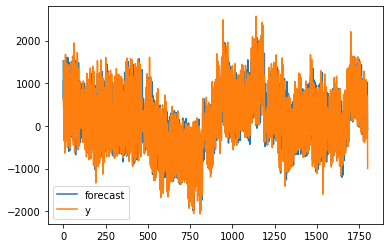

In [36]:
# making our final model
model = ARIMA(differenced, order=(9, 1, 9))
model_fit = model.fit(disp=0)
_ = model_fit.plot_predict(dynamic=False)

RMSE on trained period is: 228.47


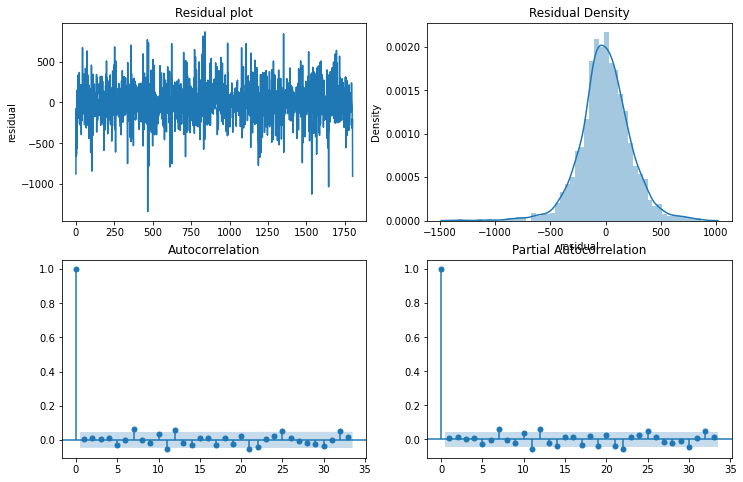

In [37]:
# Residual diagnostics
residuals = pd.DataFrame(model_fit.resid, columns=['residual'])
differenced_rmse = np.delete(differenced, 0)
predicted = differenced_rmse - residuals['residual']
for i in range(len(residuals['residual'])):
    predicted[i] = predicted[i] + df['n_first_visits'][i+1]
train = df['n_first_visits'][366:].to_numpy()
print(f'RMSE on trained period is: {np.sqrt(np.mean((predicted - train) ** 2)):.2f}')
residuals = pd.DataFrame(model_fit.resid, columns=['residual'])
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.lineplot(x=residuals.index, y="residual", data=residuals, ax=ax[0, 0])
ax[0, 0].set_title("Residual plot")
sns.distplot(residuals["residual"], ax=ax[0, 1])
ax[0, 1].set_title("Residual Density")
sm.graphics.tsa.plot_acf(residuals['residual'], ax=ax[1, 0])
_ = sm.graphics.tsa.plot_pacf(residuals['residual'], ax=ax[1, 1])

In [38]:
# Box-Ljung test for residual autocorrelation
blt = sm.stats.acorr_ljungbox(model_fit.resid, lags=9, return_df=True)
print(f"Minimum p-value: {blt['lb_pvalue'].min()}")
print(f"Median p-value: {blt['lb_pvalue'].mean()}")
print(f"Mean p-value: {np.median(blt['lb_pvalue'])}")

Minimum p-value: 0.2624083206540021
Median p-value: 0.6820455691133024
Mean p-value: 0.7917810844882341


In [39]:
def inverse_difference(history, yhat, interval):
    return yhat + history[-interval]

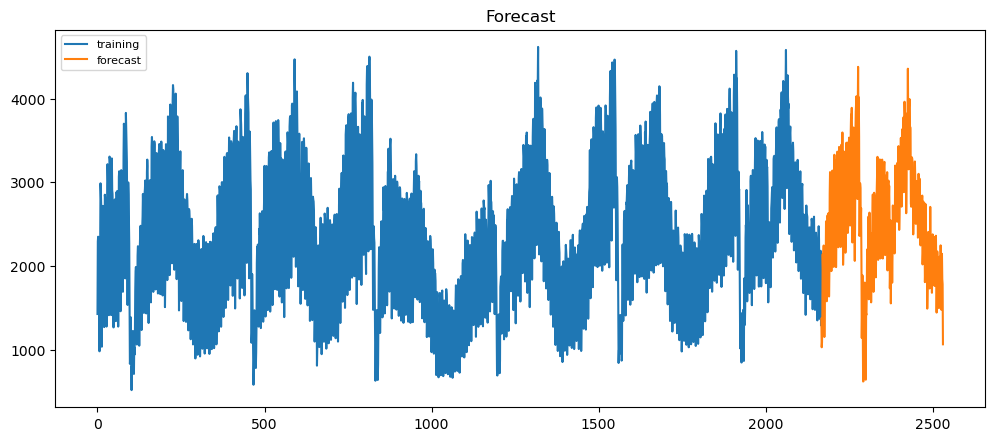

In [40]:
# calculating forecast for next 1 year
n_periods = 365
fc, se, conf = model_fit.forecast(n_periods, alpha=0.05)
history = [x for x in df['n_first_visits']]
for yhat in fc:
    inverted = inverse_difference(history, yhat, 365)
    history.append(inverted)
fc_index = np.arange(len(df['n_first_visits']), len(df['n_first_visits']) + n_periods)
fc_series = pd.Series(history[len(df['n_first_visits']): len(df['n_first_visits']) + n_periods], index=fc_index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['n_first_visits'], label='training')
plt.plot(fc_series, label='forecast')
plt.title('Forecast')
_ = plt.legend(loc='upper left', fontsize=8)